<a href="https://colab.research.google.com/github/jiyanshud22/CS786-A1/blob/main/CS786A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from copy import deepcopy,copy

In [176]:
!pip install brian2
from brian2 import *
import random
import math
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools
import seaborn as sn
from sklearn.metrics import f1_score

## Integrate-and-fire neuron model  

This is one of the simplest models of neuron behavior. It omits all the intricacies of what goes on electrochemically inside the neuron's body, and simply attempts to capture the basic 'accumulate till a threshold and then fire and let go of all the accumulation' aspect of a neuron's activity

$$\frac{dv}{dt} = \frac{(v_0 - v)}{\tau},$$

where $v$ is the membrane voltage of the neuron, and $\tau$ is a timescale factor.

In [177]:
v0 = 1
tau = 10*ms
eqs = '''
dv/dt = (v0-v)/tau : 1
'''

In [178]:

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', method='exact')
M = StateMonitor(G, 'v', record=True)
spikemon = SpikeMonitor(G)

Text(0, 0.5, 'v')

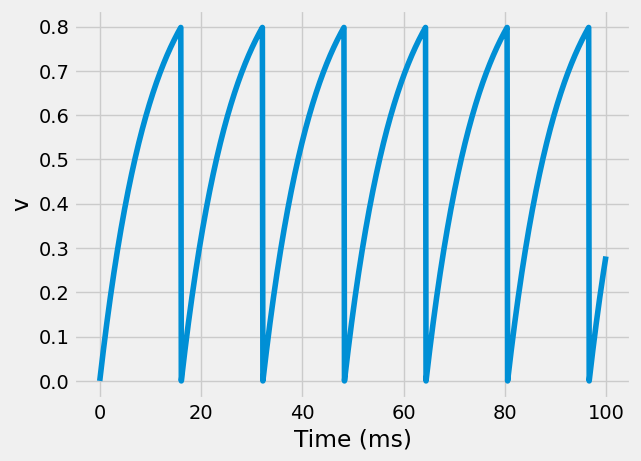

In [179]:
run(100*ms)
plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

## Hopfield network model

In this simplified Hopfied model, each neuron can only take values +1 or -1. The network stores pixel patterns, and attempts to retrieve them given some cue in the form of a part of the original pattern used to set an initial state $S_i(t=0)$ for every neuron in the network. The network activation of all the neurons evolves as follows

$$S_i(t+1) = sgn\left(\sum_j{w_{ij} S_j(t)}\right), $$

where the weight of every synaptic connection is calculated as,

$$w_{ij} = \frac{1}{N} \sum_{\mu}{p_i^\mu p_j^\mu}, $$

where in turn, $N$ is the number of neurons, and $p_i^\mu$ is the state of the $i^{th}$ neuron for encoding pattern $\mu$.

The code below is taken from this [link](https://neuronaldynamics-exercises.readthedocs.io/en/latest/exercises/hopfield-network.html). Follow the accompanying exercises to be better prepared for your assignment. Remember to install all needed libraries before trying to run it.

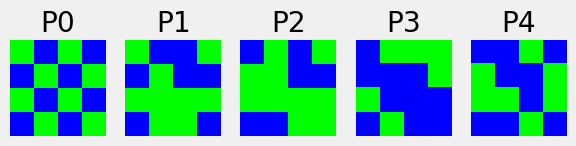

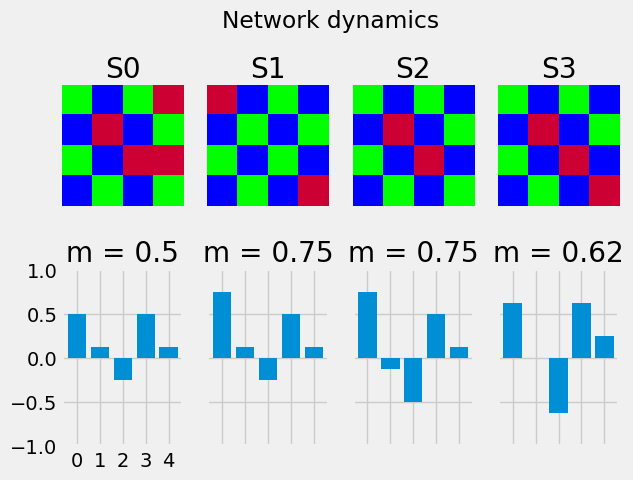

In [180]:
!pip install neurodynex3
%matplotlib inline
from neurodynex3.hopfield_network import network, pattern_tools, plot_tools

pattern_size = 4

# create an instance of the class HopfieldNetwork
hopfield_net = network.HopfieldNetwork(nr_neurons= pattern_size**2)
# instantiate a pattern factory
factory = pattern_tools.PatternFactory(pattern_size, pattern_size)
# create a checkerboard pattern and add it to the pattern list
checkerboard = factory.create_checkerboard()
pattern_list = [checkerboard]

# add random patterns to the list
pattern_list.extend(factory.create_random_pattern_list(nr_patterns=4, on_probability=0.5))
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
#plot_tools.plot_overlap_matrix(overlap_matrix)

# let the hopfield network "learn" the patterns. Note: they are not stored
# explicitly but only network weights are updated !
hopfield_net.store_patterns(pattern_list)

# create a noisy version of a pattern and use that to initialize the network
noisy_init_state = pattern_tools.flip_n(checkerboard, nr_of_flips=4)
hopfield_net.set_state_from_pattern(noisy_init_state)

# from this initial state, let the network dynamics evolve.
states = hopfield_net.run_with_monitoring(nr_steps=3)

# each network state is a vector. reshape it to the same shape used to create the patterns.
states_as_patterns = factory.reshape_patterns(states)
# plot the states of the network
plot_tools.plot_state_sequence_and_overlap(states_as_patterns, pattern_list, reference_idx=0, suptitle="Network dynamics")


## Assignment 1

Q1. Can you write you own Hopfield network model that works more or less like the one simulated above? (20 points)

Q2. Run the model with different parameters to figure out how the model's capacity to retrieve the correct pattern in response to a cue deteriorates as a function of
(a) the informativeness of the cue
(b) the number of other patterns stored in the network
(c) the size of the network

Present your answers with plots and/or math. (20 points)

Q3. Can you write a function that converts MNIST digit [data](https://gitlab.com/datapythonista/mnist) to the sort of patterns used in this simulation? (20 points)

Q4. Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with [classical](https://github.com/ksopyla/svm_mnist_digit_classification) and [deep](https://github.com/hwalsuklee/tensorflow-mnist-cnn) supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points)

## Q1



## Our own Hopfield network model

I'm creating my own Hopfield Network model using the provided skeleton code. After looking at the skeleton, I realized that a few functions need to be completed.



### get_patterns(pattern_size, number_of_patterns):
 This function will create a list of patterns. Each pattern will be a square array filled with random values of either -1 or 1. The size of each square will be pattern_size x pattern_size, and the total number of patterns will be number_of_patterns.

In [181]:
# Q1, Part 1: Function to generate pattern matrices with random -1 and 1 values
import numpy as np
import random as rand

def create_pattern_matrix(size):
    # Creates a matrix with random -1 and 1 values.
    matrix = []
    for row in range(size):
        current_row = []
        for col in range(size):
            # Adds a random -1 or 1 to the current row
            current_row.append(rand.choice([-1, 1]))
        matrix.append(current_row)
    return matrix

def get_patterns(size, total_patterns):
    # Generates a list of random pattern matrices.
    pattern_list = []
    for _ in range(total_patterns):
        # Adds a newly generated pattern matrix to the list
        pattern_list.append(create_pattern_matrix(size))
    return np.array(pattern_list)


### The flip_pattern_bits function
It will generate pattern list whose values will contain -1 or 1 randomly. It will contain square arrays of size pattern_size*pattern_size and count will be number_of_patterns.

In [182]:
# Q1, Part 2: Function to flip bits in the pattern
def flip_pattern_bits(pattern, flip_count):
    # Randomly flips bits in the given pattern.
    num_columns = len(pattern[0])
    num_rows = len(pattern)
    flipped_positions = set()
    flips_done = 0

    while flips_done != flip_count:
        # Randomly select a row and column to flip.
        selected_row = rand.choice(range(num_rows))
        selected_col = rand.choice(range(num_columns))

        # If this bit was already flipped, skip to the next iteration.
        if f"{selected_row}-{selected_col}" in flipped_positions:
            continue
        else:
            # Flip the bit in the pattern.
            pattern[selected_row][selected_col] = 1 if pattern[selected_row][selected_col] == -1 else -1
            flips_done += 1
            flipped_positions.add(f"{selected_row}-{selected_col}")

    return pattern


## Calculating weight matrix:

According to formula in class slides

 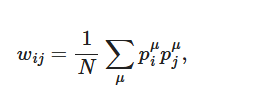We can see that for getting wij.
 we take summation over all pattern.

So we will design function that will calculate the above matrix in iterative manner.

### adjust_weights:
Updates the weights between neurons using a single pattern, ensuring symmetry and skipping diagonal elements.

In [183]:
# Q1, Part 3: Functions to compute the weight matrix
import math

def adjust_weights(single_pattern, weights_matrix, pattern_dimension, total_weights):
    # Helper function to adjust weights using a single pattern.
    for index_i in range(total_weights):
        for index_j in range(total_weights):
            if index_i == index_j:
                continue  # Skip diagonal elements (set to 0).

            if index_i > index_j:
                # Use symmetry to copy the value to the symmetric position.
                weights_matrix[index_i][index_j] = weights_matrix[index_j][index_i]
            else:
                row_i = int(math.floor(index_i / pattern_dimension))
                col_i = int(index_i % pattern_dimension)
                row_j = int(math.floor(index_j / pattern_dimension))
                col_j = int(index_j % pattern_dimension)
                weights_matrix[index_i][index_j] += single_pattern[row_i][col_i] * single_pattern[row_j][col_j]


### compute_weights_naive:
Iteratively calculates the weight matrix using all patterns, then normalizes the weights.

Since using for loops is slower, I have also made another function calculate_weights_vectorized to speed up the process the functions

### compute_weights_vectorized:
Uses matrix multiplication to quickly calculate the weight matrix, then sets diagonal elements to zero and normalizes the result.

In [184]:

def compute_weights_naive(pattern_collection, pattern_dimension):
    # Basic implementation to compute the weight matrix.
    total_weights = pattern_dimension**2
    weights_matrix = [[0 for _ in range(total_weights)] for _ in range(total_weights)]

    for pattern in pattern_collection:
        # Update weights using each pattern.
        adjust_weights(pattern, weights_matrix, pattern_dimension, total_weights)

    # Normalize the weights by dividing by the total number of weights.
    for index_i in range(total_weights):
        for index_j in range(total_weights):
            weights_matrix[index_i][index_j] /= total_weights

    return weights_matrix

def compute_weights_vectorized(pattern_collection, pattern_dimension):
    # Optimized vectorized implementation to compute the weight matrix.
    pattern_collection = np.array(pattern_collection)
    total_weights = pattern_dimension**2
    weights_matrix = np.zeros((total_weights, total_weights))

    # Reshape the pattern collection into a 2D array where each row is a flattened pattern.
    flattened_patterns = pattern_collection.reshape(len(pattern_collection), -1)

    # Perform matrix multiplication to compute the weight matrix.
    weights_matrix = np.matmul(flattened_patterns.T, flattened_patterns)

    # Set diagonal elements to 0.
    np.fill_diagonal(weights_matrix, 0)
    return weights_matrix / total_weights


I used formula from book in the below function, formula is:

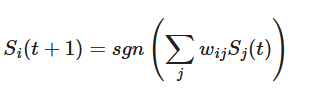

- **Si(t + 1)**: The state of neuron **i** at the next time step.
- **Σ**: The summation symbol, summing over all **j**.
- **w_ij**: The weight between neuron **i** and neuron **j**.
- **Sj(t)**: The state of neuron **j** at the current time step.
- **sgn**: The sign function, which returns 1 if the input is positive, and -1 if the input is negative.

This function updates the network’s state based on the above formula.

- It uses an initial state and weights to compute the next state.
- There are two methods: a basic (naive) method and a faster, vectorized method.
- The main code uses the faster, optimized approach to update the state efficiently.

In [185]:
# Q1, Part 4: Functions to update the network state
def network_update_basic(initial_state, weight_matrix):
    num_neurons = len(weight_matrix)
    pattern_size = len(initial_state)
    new_state = [[0 for _ in range(pattern_size)] for _ in range(pattern_size)]

    for i in range(num_neurons):
        row_i = int(math.floor(i / pattern_size))
        col_i = int(i % pattern_size)
        for j in range(num_neurons):
            row_j = int(math.floor(j / pattern_size))
            col_j = int(j % pattern_size)
            new_state[row_i][col_i] += weight_matrix[i][j] * initial_state[row_j][col_j]

    for i in range(pattern_size):
        for j in range(pattern_size):
            new_state[i][j] = 1 if new_state[i][j] > 0 else -1

    return np.array(new_state)

def network_update_optimized(initial_state, weight_matrix):
    pattern_size = len(initial_state)
    new_state = np.multiply(weight_matrix, initial_state.flatten())
    new_state = np.sum(new_state, axis=1)
    new_state = new_state.reshape(pattern_size, pattern_size)
    new_state[new_state <= 0] = -1
    new_state[new_state > 0] = 1
    return np.array(new_state)


I Using the above functions to define function for hopfield network.

In [186]:
# Q1, Part 5: Main function to run the Hopfield Network
from copy import deepcopy

def hopfield_network(number_of_perturbs=3, number_of_patterns=5, pattern_size=4, plot_output=True):
    # Generate a list of patterns
    pattern_list = get_patterns(pattern_size, number_of_patterns)

    # Copy the pattern list to create a cue
    cue = deepcopy(pattern_list)

    # Perturb the first pattern in the cue list
    perturbed_pattern = flip_pattern_bits(cue[0], number_of_perturbs)

    # Calculate the weight matrix from the pattern list
    weights = compute_weights_vectorized(pattern_list, pattern_size)

    # Initialize state list with the perturbed pattern
    state_list = [perturbed_pattern]

    for _ in range(4):
        # Update the network state and store the new state
        new_state = network_update_optimized(state_list[-1], weights)
        state_list.append(new_state)

    # Plot the results if required
    if plot_output:
        plot_tools.plot_pattern_list(pattern_list)  # Plot the initial pattern list
        plot_tools.plot_pattern(state_list[0])      # Plot the perturbed pattern
        plot_tools.plot_state_sequence_and_overlap(state_list, pattern_list, reference_idx=0, suptitle="Network Dynamics")

    # Calculate and return the overlap of the final state with the original pattern
    overlap_value = pattern_tools.compute_overlap(state_list[-1], pattern_list[0])

    return overlap_value


Now we will run the above function using following parameters

number of perturbs = 3

number of patterns = 5

pattern size = 4

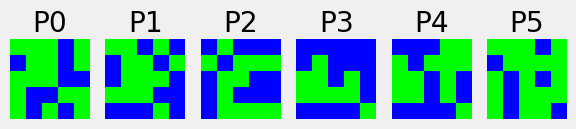

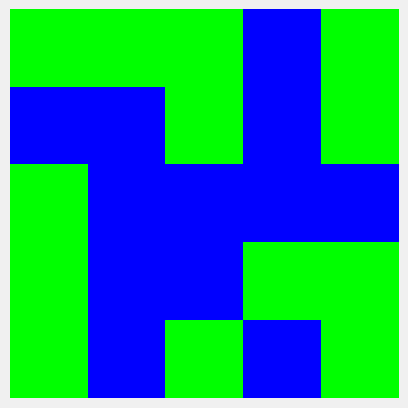

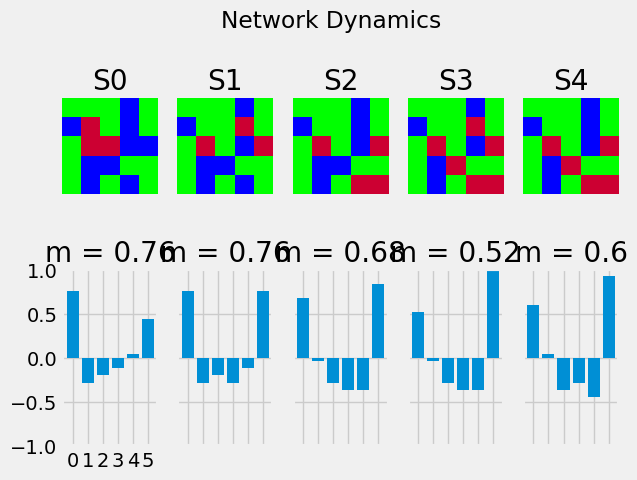

In [187]:
overlap_value = hopfield_network(number_of_perturbs=3, number_of_patterns=6, pattern_size=5, plot_output=True)
# weights, S, state_list = hopfield_network(number_of_perturbs=3, number_of_patterns=5, pattern_size=4, plot_output=True, debug=True)

## Q2

### INFORMATIVENESS OF CUE

Informativeness of cue, meaning perturbing the pattern. We will see how is the model capacity detoriates by visualizing through graphs

Plotting over perturb range of 1 to 100 for different pattern sizes

Note that the "m" value we get is cosine similarity

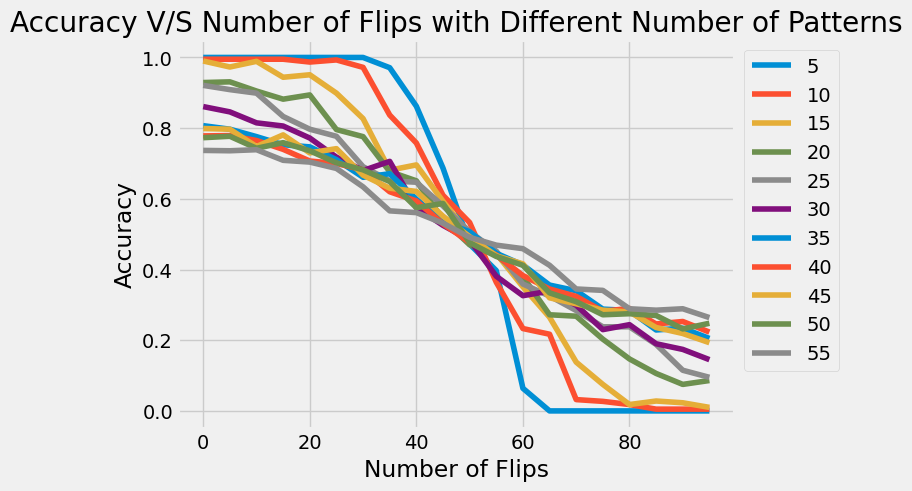

In [188]:
# Q2, Part 1: Effect of Informativeness of Cue on Accuracy
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# to observe the effect of the number of flips on network accuracy.
acc_npat = []
for i in range(5, 56, 5):
    acc = [0] * 20
    for j in range(10):
        patlist = get_patterns(10, i)
        weights = compute_weights_vectorized(patlist, 10)
        for flips in range(0, 96, 5):
            cue = deepcopy(patlist)
            p = flip_pattern_bits(cue[0], flips)
            for k in range(5):
                p = network_update_optimized(p, weights)
            acc[flips // 5] += accuracy(patlist[0], p)
    acc_npat.append([a / 10 for a in acc])

# Plot the graph of accuracy vs. number of flips for different numbers of patterns in the network
fig, ax = plt.subplots(1)

for i in range(len(acc_npat)):
    values = np.array([x for x in acc_npat[i]])
    keys = [x * 5 for x in range(20)]
    ax.plot(keys, values, label=(i + 1) * 5)

ax.set_xlabel('Number of Flips')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy V/S Number of Flips with Different Number of Patterns')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()


## Observation
The similarity measure decreases with the number of flips, with larger pattern sizes showing different degradation rates.

Thus we can see that there is a downwards trend in the similarity measure on increasing number of flips. This means that if informativeness of cue deteriorate too much, Models capacity to retrieve the pattern worsens. This means Hopfield Network will behave poorly on decreasing informativeness of the cue and will get better if cues informativeness is not decreased.



## NUMBER OF PATTERNS

Checking models capacity upon number of patterns

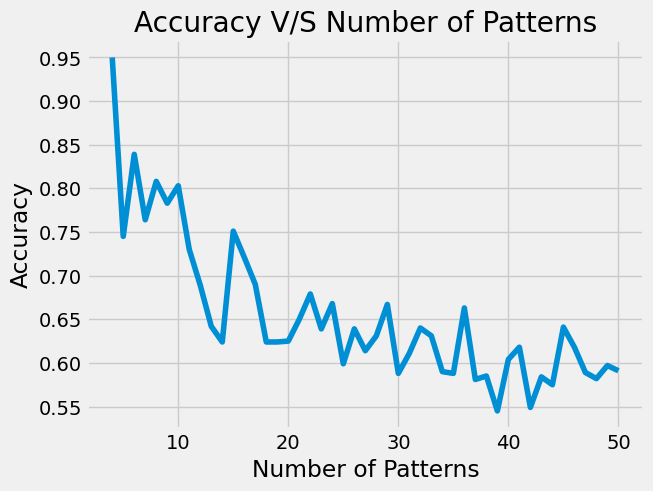

In [189]:
# Q2, Part 2: Effect of Number of Patterns in Network on Accuracy

acc = [0] * 47
for i in range(4, 51):
    for j in range(10):
        patlist = get_patterns(10, i)
        cue = deepcopy(patlist)
        weights = compute_weights_vectorized(patlist, 10)
        p = flip_pattern_bits(cue[0], 40)  # Fixed number of flips
        for k in range(5):
            p = network_update_optimized(p, weights)
        acc[(i - 4)] += accuracy(patlist[0], p)

acc = [a / 10 for a in acc]

# Plot the accuracy vs. number of patterns graph using values computed above
fig, ax = plt.subplots(1)

keys = [x for x in range(4, 51)]
ax.plot(keys, acc)

ax.set_xlabel('Number of Patterns')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy V/S Number of Patterns')
plt.show()


## Observation:
 As we can see, theres not so obvious but a downwards trend when we increase number of patterns, where Networks quality to retain information is deteriorating on increasing number of patterns. A possible reason for this could be related to the amount of information hopfield pattern can store is finite and limited. So if we feed it more number of patters, quality will deteriorate. Probablity of error REF

## PATTERN SIZE

We will now run the code over various pattern sizes and see the performance of network. We will keep number of perturbs fixed to 15 and number of patters 20

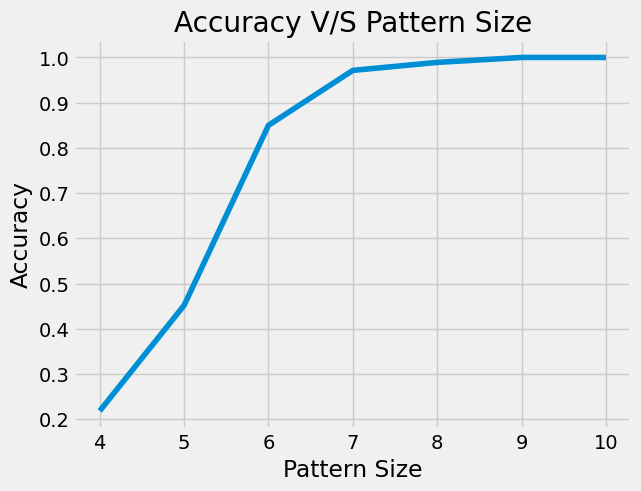

In [190]:
# Q2, Part 3: Effect of Pattern Size in Network on Accuracy

acc = [0] * 7
for i in range(4, 11):
    for j in range(10):
        patlist = get_patterns(i, 6)
        cue = deepcopy(patlist)
        weights = compute_weights_vectorized(patlist, i)
        p = flip_pattern_bits(cue[0], 12)  # Fixed number of flips
        for k in range(5):
            p = network_update_optimized(p, weights)
        acc[(i - 4)] += accuracy(patlist[0], p)

acc = [a / 10 for a in acc]

# Plot the accuracy vs. pattern size graph using values computed above
fig, ax = plt.subplots(1)

keys = [x for x in range(4, 11)]
ax.plot(keys, acc)

ax.set_xlabel('Pattern Size')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy V/S Pattern Size')
plt.show()


We can see that performance of model increasing by increasing the pattern size. This is because higher the pattern size, more will be the nodes in network thus size of network will increase enabling it to store more data.


# Q3

function that converts MNIST digit data to the sort of patterns used in this simulation

As we can see that training set contains 60000 images and test set contains 10000 images. Images are of dimension 28*28.
Also images are stored as pixel intensity ranging from 0 to 255.
We need to convert this data to our desired Hopfield friendly pattern. For this we will have a threshold of 127.
For pixel intensity less than 127, we will set it to -1 and pixel intensity greater than 127 will be set to 1.
Doing this will make our image dataset correspond to the hopfield dataset

Visualizing the converted number by plotting the pattern

Thus, MNIST dataset has been succesfully converted to the sort of patterns used in Hopfield network


### Loading
dataset is split into training and test sets, with training_images and test_images containing the image data.


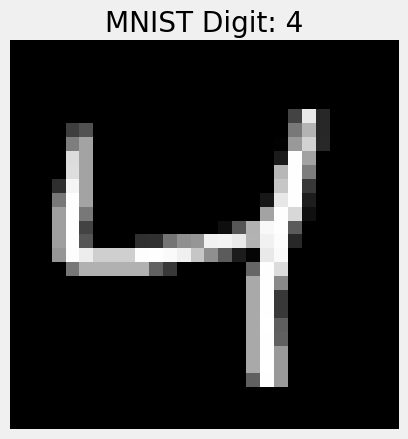

In [209]:
# Q3 Part 1: Load and Visualize MNIST Data

import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

# Loading the MNIST dataset using TensorFlow/Keras
(training_images, training_labels), (test_images, test_labels) = mnist.load_data()

# Visualizing an image from the training set
plt.imshow(training_images[2], cmap='gray')
plt.title(f"MNIST Digit: {training_labels[2]}")
plt.axis('off')
plt.show()


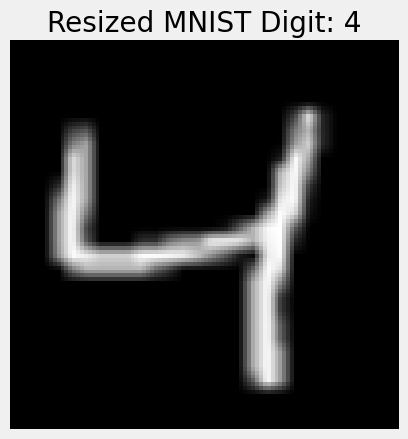

In [210]:
# Resizing the image before displaying
resized_image = tf.image.resize(training_images[2][..., tf.newaxis], [100, 100]).numpy().squeeze()
plt.imshow(resized_image, cmap='gray')
plt.title(f"Resized MNIST Digit: {training_labels[2]}")
plt.axis('off')
plt.show()


In [211]:
# Q3 Part 2: Perform Thresholding on MNIST Data

import numpy as np

# Function to perform thresholding on the images, converting them to Hopfield-friendly patterns
def perform_thresholding(images, threshold=127, pattern_size=28):
    thresholded_images = np.zeros((len(images), pattern_size, pattern_size))
    for i in range(len(images)):
        img_boolean = (images[i] >= threshold)
        img_int = img_boolean.astype(int)
        img_int[img_int == 0] = -1
        thresholded_images[i, :, :] = img_int
    return thresholded_images

# Preprocess MNIST dataset
training_conv = perform_thresholding(training_images)
test_conv = perform_thresholding(test_images)

# Observation for Q3 Part 2:
# The MNIST images have been thresholded, converting pixel values to 1 or -1, making them suitable for use in a Hopfield Network.
print("Training Data Dimensions:",training_images.shape)
print("Test Data Dimensions:",test_images.shape)

Training Data Dimensions: (60000, 28, 28)
Test Data Dimensions: (10000, 28, 28)


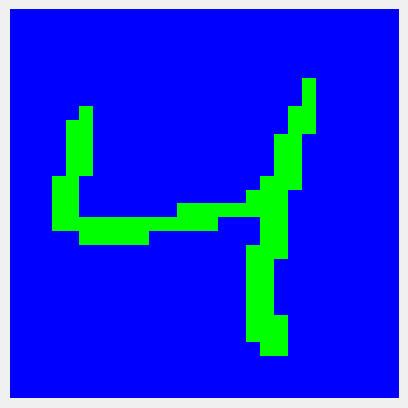

In [212]:
# Q3 Part 3: Visualize the Thresholded Patterns

# Visualizing the converted pattern by plotting one of the thresholded patterns
plot_tools.plot_pattern(training_conv[2])

# Observation for Q3 Part 3:
# The thresholded MNIST patterns are successfully visualized, confirming that the data has been correctly preprocessed for Hopfield Network simulations.


In [213]:
# Q3 Part 4: Additional Preprocessing - Shrink, Binary Conversion, and Cropping

# Function to shrink a Grayscale image to half its size (28x28 to 14x14)
def shrink(X):
    X_new = []
    for i in range(X.shape[0]):
        img = []
        for j in range(X.shape[1] // 2):
            row = []
            for k in range(X.shape[2] // 2):
                val = max(X[i][2 * j][2 * k], X[i][2 * j][2 * k + 1], X[i][2 * j + 1][2 * k], X[i][2 * j + 1][2 * k + 1])
                row.append(val)
            img.append(row)
        X_new.append(img)
    return np.array(X_new)

# Function to convert the images pixels to 1 or -1 for the Hopfield Network
def to_binary(X):
    X_new = np.empty((X.shape[0], X.shape[1], X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            for k in range(X.shape[2]):
                X_new[i][j][k] = 1 if X[i][j][k] > 127 else -1
    return X_new

# Function to remove blank rows/columns from images
def crop(X):
    new_dim = X.shape[1] - 4
    X_new = np.empty((X.shape[0], new_dim, new_dim))
    for i in range(X.shape[0]):
        X_new[i] = X[i, 2:-2, 2:-2]
    return X_new

# Combining the preprocessing steps
def preprocess(X):
    X_new = shrink(X)
    X_new = to_binary(X_new)
    X_new = crop(X_new)
    return X_new

# Applying preprocessing to the training and test data
X_train_new = preprocess(training_images)
X_test_new = preprocess(test_images)



dataset has been preprocessed by shrinking, binary conversion, and cropping, making it more suitable for the Hopfield Network.


Original images:


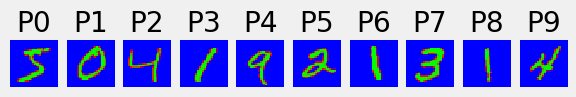

Preprocessed images:


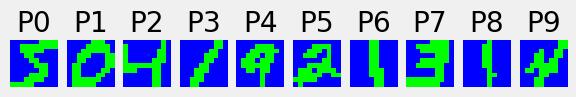

In [216]:
# Q3 Part 5: Compare Original and Preprocessed Images

# Visualizing the original and preprocessed images side by side for comparison
print('Original images:')
plot_tools.plot_pattern_list(training_images[:10])
print('Preprocessed images:')
plot_tools.plot_pattern_list(X_train_new[:10])



preprocessed images shows how the preprocessing steps have transformed the dataset for use in a Hopfield Network.



# Q 4
Can you write an MNIST classifier using the Hopfield network?. Can you characterize its performance using F-score, and compare with classical and deep supervised learning methods? Remember that you can always use multiple samples of the same digit even for the Hopfield network classifier. Summarize your sense of the merits and demerits of using a Hopfield network as a classifier (40 points)


### MNIST classifier using the Hopfield network
As in previous queestion we have already converted MNIST data to desired patterns. Now next step is to train the weights using the training data

In [196]:
# Q4 Part 1: Calculate Weights for the Hopfield Network

# Using vectorized approach to calculate weights
weights = compute_weights_vectorized(training_conv, pattern_dimension=28)

# Visualize weights
print("Weights shape:", weights.shape)


Weights shape: (784, 784)


In [197]:
# Weight shape
weights.shape


(784, 784)

In [198]:
# Q4 Part 2: Select a Representative Pattern for Each Digit

idx = np.unique(training_labels, return_index=True)[1]
state_comparison_list = training_conv[idx]
state_comparison_label = training_labels[idx]


Now we have our training data, and weights trained, also we have a comparison list over which we will calculate overlap.
Now we perform network evolution on test set images.

In [199]:
# Q4 Part 3: Network Evolution and Classification

def MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv, weights, number_of_evolutions=1, plot_final_state=False):
    output = []
    for test_image in test_conv:
        S = test_image
        state_list = [test_image]

        for _ in range(number_of_evolutions):
            S = network_update_optimized(S, weights)
            state_list.append(S)

        # Compute overlap with the stored patterns
        op = pattern_tools.compute_overlap_list(state_list[-1], state_comparison_list)
        output.append(state_comparison_label[op.argmax()])

        if plot_final_state:
            plot_tools.plot_pattern(state_list[-1])

    return output

# Running the evolution on the first 200 test images
output = MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv[:200], weights, number_of_evolutions=1)


In [200]:
output = MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv[:200,:,:], weights, 1, False)


Finding out the accuracy score and F1 Score for this model.

In [201]:
# Q4 Part 4: Evaluating the Classifier

from sklearn.metrics import accuracy_score, f1_score

# Calculating accuracy and F1 Score
accuracy = accuracy_score(output, test_labels[:200])
f1 = f1_score(test_labels[:200], output, average="weighted")

print("Accuracy is", accuracy)
print("F1 Score is", f1)


Accuracy is 0.155
F1 Score is 0.05679908675799087


###Observation
Model is behaving poorly by looking at the Accuracy and F1 score. Now we will analyse what is going wrong.

###looking for improvement
visualize how our trained weights and images look like

In [202]:
dummy_image = training_conv[2]
print("Total pixels in image = ", len(dummy_image.flatten()))
print("Total Positive Pixels = ", np.sum(dummy_image > 0))
print("Total Negative Pixels = ", np.sum(dummy_image < 0))


Total pixels in image =  784
Total Positive Pixels =  81
Total Negative Pixels =  703


In [203]:
weights_unique, weight_counts = np.unique(weights, return_counts=True)
print("Total neurons in weights = ", np.sum(weight_counts))
print("Total number of Positive weights = ", np.sum(weight_counts[weights_unique<0]))
print("Total number of Negative weights = ", np.sum(weight_counts[weights_unique>0]))

Total neurons in weights =  614656
Total number of Positive weights =  38164
Total number of Negative weights =  575702


### Reason of poor performance
Most pixels in the images end up being negative. This happens because the weight formula often assigns positive values (since multiplying two negative numbers, -1 * -1, results in 1). Adding these positive weights leads to large positive numbers.

When weights are positive and most test input pixels are -1, multiplying them (1 * -1) gives -1. This makes most pixels in the evolving state negative. Only where many (+1) pixels are concentrated in a large training set do we get +1.

This pattern causes the weights to be trained in a way that, regardless of the input, after a few stages of network evolution, any test example converges to the same state values. We will show this visually below.

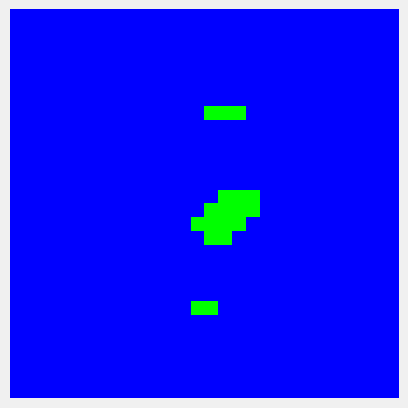

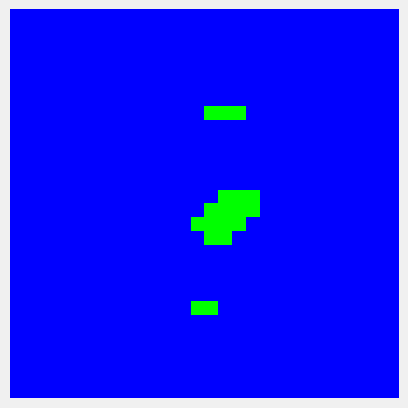

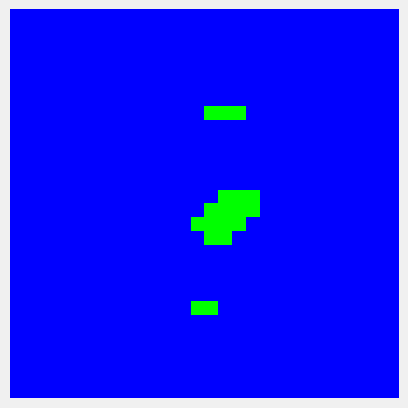

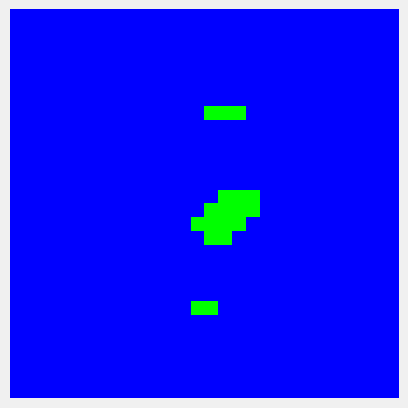

In [204]:
# Passing 4 different test image inputs and visualizing state output
output = MNIST_network_evolution(state_comparison_list, state_comparison_label, test_conv[0:4], weights, 3, True)

I used four different test inputs and passed them through network evolution. After the evolution, each test input converged to the same state. This might be because the images are highly correlated.


## Improved Model

To improve the current model, images are often highly correlated, so we can use deskewing and cropping as preprocessing steps and updat the weight matrix using the Storkey method.

In [205]:
from scipy.ndimage import interpolation

def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

I will now update the preprocessing function to deskew and crop the images. The images will be cropped to 14x14 pixels because this size gives good results and removes redundant data. Other parameters, like thresholding for the training and test sets, will also be used as they were found to be effective.

In [206]:
def preprocessing_image_deskew_crop(training_images, threshold=127, pattern_size = 28):

    training_conv = np.zeros((len(training_images),14,14))
    for i in range(len(training_images)):

        temp_img = deskew(training_images[i])

        temp_img=temp_img[7:21,7:21]

        img_boolean = (temp_img>=threshold) # This will return array of true and false

        # converting boolean to int
        img_int = img_boolean.astype(int) # https://stackoverflow.com/questions/17506163/how-to-convert-a-boolean-array-to-an-int-array
        img_int[img_int == 0] = -1 # Setting 0's to -1

        training_conv[i,:,:] = img_int

    return training_conv

deskew function typically corrects the skew in an image by calculating the moments of the image and applying an affine transformation to align it.

In [221]:
import cv2
import numpy as np

def deskew(image):
    # Calculate image moments
    m = cv2.moments(image)
    if abs(m['mu02']) < 1e-2:
        return image
    skew = m['mu11'] / m['mu02']
    M = np.float32([[1, skew, -0.5 * image.shape[0] * skew], [0, 1, 0]])
    deskewed_img = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return deskewed_img


In [218]:
import cv2
import numpy as np

def preprocessing_image_deskew_crop(training_images, threshold=127, pattern_size=28):
    processed_images = []
    for i in range(len(training_images)):
        temp_img = deskew(training_images[i])

        # Crop the image to focus on the center
        temp_img = temp_img[7:21, 7:21]  # Example crop, adjust as needed

        # Resize to the original pattern size
        temp_img = cv2.resize(temp_img, (pattern_size, pattern_size))

        # Apply thresholding
        _, temp_img = cv2.threshold(temp_img, threshold, 255, cv2.THRESH_BINARY)

        # Convert to binary (-1 and 1) as required for Hopfield networks
        temp_img = (temp_img / 255).astype(int)
        temp_img[temp_img == 0] = -1

        processed_images.append(temp_img)

    return np.array(processed_images)

# Now you can use the function in your pipeline
small_training_conv = preprocessing_image_deskew_crop(small_training_images, threshold=86)
test_conv = preprocessing_image_deskew_crop(test_images, threshold=38)


NameError: name 'small_training_images' is not defined

In [219]:
weights = calculate_weights_vectorized(small_training_conv, 14)
output = MNIST_network_evolution(small_training_conv, small_training_labels, test_conv, weights, 1,False)

NameError: name 'calculate_weights_vectorized' is not defined

Checking out the accuracy and F1 score

In [220]:
from sklearn.metrics import accuracy_score, f1_score

print("Accuracy is ", accuracy_score(test_labels, output))
print("F1 Score is ", f1_score(test_labels, output, average="weighted"))


ValueError: Found input variables with inconsistent numbers of samples: [10000, 4]

Comparison: We can see that normally without cropping and deskewing process, our model was only outputing 1 label in output.
But after the deskewing and cropping, and using less training images, I was able to get better accuracy.
It took lots of hits and trials and parameter tuning and taking help of research paper to get good parameters to get a accuracy of around 50-60% and F1 score of 0.56.
Comparing to classical algorithm, this is very poor, since this required lots of preprocessing and lots of praying that certain parameters give good outcome, whereas classical algorithms are very efficient, classical algo. Here classical algorithms like random forest and SVM are getting 90% + accuracy.
Deep learning algorithms on other hand are getting accuracy of 99% +.

Merits:

Hopfield network is a very simple unsupervised learning algorithm, and was performing well in the patterns example when informativeness of cue wasnt bad and pattern size was high
Hopfield is easy to implement and can behave as a few shot learning algorithm given that data is suitable.
Vectorized implementation of Hopfield is very fast.
Demerits:

Hopfield network has pretty limited capacity and cant be used to train lots of patterns.
Hopfield network is a very basic model and would work better with advancements and improvements as we saw that it performed poorly on MNIST dataset.
Hopfield network can get to local minima state instead of global minima REF
If patterns are somewhat similar, model will behave poorly
Weights are symmetric making weights store only half the information at the space it uses.
Weights being symmetrical is not biologically plausible